# Many body localization in 2-D qubit array

This simulation is based on the paper -- "Quantum Neuronal Sensing of Quantum Many-Body States on a 61-Qubit
Programmable Superconducting Processor". and aimed to demostrate the performance of quantum machine learning viaTeD-Q module.
### Many Body localization
Many-body localization is a quantum phenomenon of an isolated many-body quantum system. The system tend to preserve the initial state under large disorder, known as localized state. On the other hand, with small disorder, the system tend to fall into the thermalization, that is, the infomation of initial state is washed out, known as ergodic state.

<img src="images/mbl_2d.png" width=1000 />
(figure adapted from [1])

### Circuit design
The circuit design follows the one proposed in the paper. The circuit starts with an preparation stage for Neel state and followed by a system Hamiltonian with controllable disorder power. After that, the circuit is embeded with a variational cirucit via digital-analog architecture[1]. Finally, the measurement on first qubit is the output stage. We train the output probability to distinguish localized state from ergodic state.


### About this simulation
This circuit is suitable for the demostration of the computing power of TeD-Q package due to its complexity. In the simulated hamilonian of the system, the qubits was connected to all of its neighbor qubits. For a 2-D qubits array, such connection will introduce lot of 2-qubit operation and single-qubit operation, which becomes too complicated for the conventional quantum machine learning simulator.

## Reference
1. https://arxiv.org/pdf/2201.05957.pdf
2. https://arxiv.org/pdf/1804.11065.pdf

In [1]:
### init parameters#import sys
#sys.path.append('..')
import torch
import tedq as qai
import numpy as np
import math
from torch.optim import lr_scheduler

### init parameters

In [2]:
n_size = 3 # 3
n_epoch = 50
n_train = 40
n_test = 50

lr = 0.01
gamma_lr_scheduler = 0.2

n_qubits= n_size*n_size
t_d = 200e-9 #ns
h_bar = 1
g = 2.185e6 #MHz
h_erg = 1e6 # MHZ
h_loc = 40e6  # MHz

### Circuit definition

In [3]:
### Circuit definition
def getIndex(i, j):
    return n_size*i+j
def Hd(idx, jdx, di):
    #qai.RZ(2*h_bar*di*t_d, qubits=[jdx], trainable_params=[])
    qai.RZ(di, qubits=[jdx])
    H0(idx, jdx)
    
def H0(idx, jdx):
    qai.Hadamard(qubits=[idx])
    qai.Hadamard(qubits=[jdx])
    qai.CNOT(qubits=[idx, jdx])
    qai.RZ(torch.Tensor([g*h_bar*t_d]), qubits=[jdx], trainable_params=[])
    qai.CNOT(qubits=[idx, jdx])
    qai.Hadamard(qubits=[idx])
    qai.Hadamard(qubits=[jdx])
    
    qai.S(qubits=[idx])
    qai.S(qubits=[jdx])
    qai.Hadamard(qubits=[idx])
    qai.Hadamard(qubits=[jdx])
    qai.CNOT(qubits=[idx, jdx])
    qai.RZ(torch.Tensor([g*h_bar*t_d]), qubits=[jdx], trainable_params=[])
    qai.CNOT(qubits=[idx, jdx])
    qai.Hadamard(qubits=[idx])
    qai.Hadamard(qubits=[jdx])
    qai.PhaseShift(torch.tensor(-math.pi/2.), qubits=[idx], trainable_params=[])
    qai.PhaseShift(torch.tensor(-math.pi/2.), qubits=[jdx], trainable_params=[])
    #qai.S(qubits=[idx]).adjoint()# add adjoint here will not change circuit's operator
    #qai.S(qubits=[jdx]).adjoint()
    
def circuitDef(d, params):
    
    params = params.view(-1)
    
    # Neel state
    for i in range(n_size):
        for j in range(n_size):
            if (i+j)%2==0:
                qai.PauliX(qubits=[getIndex(i,j)])
    
    # Hd td
    count = 0
    for i in range(n_size):
        for j in range(n_size):
            if i+1>=0 and i+1<n_size:# (n_size-1)*n_size
                Hd(getIndex(i+1, j), getIndex(i,j), d[count])
                count+=1
            if i-1>=0 and i-1<n_size:# (n_size-1)*n_size
                Hd(getIndex(i-1, j), getIndex(i,j), d[count])
                count+=1
            if j+1>=0 and j+1<n_size:# n_size*(n_size-1)
                Hd(getIndex(i, j+1), getIndex(i,j), d[count])
                count+=1
            if j-1>=0 and j-1<n_size:# n_size*(n_size-1)
                Hd(getIndex(i, j-1), getIndex(i,j), d[count])
                count+=1
    #print("count:  ", count)
    
    
    
    
                
    # Trainable theta and phi
    for i in range(n_qubits):
        #print(i)
        qai.RY(params[2*i], qubits=[i])
        qai.RX(params[2*i+1], qubits=[i])
        qai.RY(-params[2*i], qubits=[i])
    
    # H0 dt     
    for i in range(n_size):
        for j in range(n_size):
            if i+1>=0 and i+1<n_size:
                H0(getIndex(i+1, j), getIndex(i,j))
            if i-1>=0 and i-1<n_size:
                H0(getIndex(i-1, j), getIndex(i,j))
            if j+1>=0 and j+1<n_size:
                H0(getIndex(i, j+1), getIndex(i,j))
            if j-1>=0 and j-1<n_size:
                H0(getIndex(i, j-1), getIndex(i,j))
    
    
    # Last rotation  
    qai.RY(params[2*n_qubits], qubits=[n_qubits-1])
    qai.RX(params[2*n_qubits+1], qubits=[n_qubits-1])
    qai.RY(params[2*n_qubits], qubits=[n_qubits-1])
    #RZ
    
#     qai.measurement.expval(qai.PauliZ(qubits=[0]))
    qai.measurement.probs(qubits=[n_qubits-1])
    


In [4]:
N = n_size*(n_size-1)*4

In [5]:
circuit = qai.Circuit(circuitDef, n_qubits, torch.rand(N), torch.rand(n_qubits+1,2))
#circuit = qai.Circuit(circuitDef, n_qubits, parameter_shapes = [(N,), (n_qubits+1,2)])

### Draw the circuit

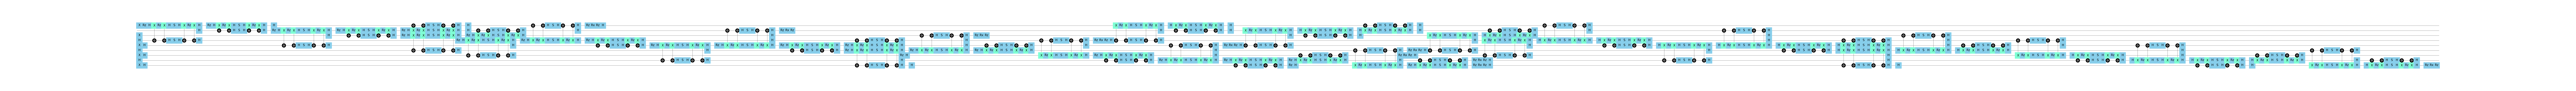

In [6]:
drawer = qai.matplotlib_drawer(circuit, dpi=2000, scale=0.001)
drawer.draw_circuit()

### Compile the circuit
#### Compiled the circuit by normal method

In [7]:
#my_compilecircuit = circuit.compilecircuit(backend="pytorch" )

#### Compiled the circuit by hyper-optimized method with JDOptTN

In [8]:
%%time
from jdtensorpath import JDOptTN as jdopttn
slicing_opts = None#{'target_size':2**28, 'repeats':328, 'target_num_slices':4, 'contract_parallel':False}
hyper_opt = {'methods':['kahypar'], 'max_time':120, 'max_repeats':4, 'progbar':True, 'minimize':'size', 'search_parallel':True, 'slicing_opts':slicing_opts}
my_compilecircuit = circuit.compilecircuit(backend="pytorch", use_jdopttn=jdopttn, hyper_opt = hyper_opt, tn_simplify=False)

log10(flops) of this quantum circuit:   6.257905020790583


2022-10-24 19:05:45,744	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265


log2(size) before slicing:  18.0
log10(flops) before removed:    7.6737474242498545
CPU times: user 5.58 s, sys: 892 ms, total: 6.47 s
Wall time: 25.1 s


#### Compiled the circuit by hyper-optimized method with CoTenGra?

In [9]:
### Prepare the training data#import cotengra as ctg
#slicing_opts = {'target_size':2**28}
#hyper_opt = {'methods':['kahypar'], 'max_time':120, 'max_repeats':2, 'progbar':True, 'minimize':'size', 'slicing_opts':slicing_opts}
#my_compilecircuit = circuit.compilecircuit(backend="pytorch", use_cotengra=ctg, hyper_opt = hyper_opt, tn_simplify=False)

### Prepare the training data

In [10]:
params = torch.rand(n_qubits+1,2, requires_grad=True)


d_erg = torch.tensor(np.random.rand(int(n_train/2), N)*2-1)*h_erg*h_bar*t_d*math.pi
d_local = torch.tensor((np.random.rand(int(n_train/2), N)*39/40.+1/40.)*np.random.choice([-1., 1.], size=(int(n_train/2), N))*h_loc*h_bar*t_d*math.pi)
#d_local = torch.tensor(np.random.rand(int(n_train/2), N)*2-1)*h_loc*h_bar*t_d*math.pi
d = torch.cat((d_erg, d_local), 0)

y_target = torch.Tensor(np.array([1]*int(n_train/2)+[0]*int(n_train/2)))


### Train the QNN circuit

In [11]:
rnd_sq = np.arange(n_train)
np.random.shuffle(rnd_sq)

In [12]:
import torch.nn as nn



optimizer = torch.optim.Adam([params], lr=0.1)

rnd_sq = np.arange(n_train)


target_list = [0 for _ in range(n_train)]
y_list = [0 for _ in range(n_train)]

for epoch in range(n_epoch):
    np.random.shuffle(rnd_sq)
    l_sum = 0
    
    for i in rnd_sq:
        w = y_target[i]*2+1
        loss = nn.BCELoss(reduction='mean')
        cir_params = torch.cat((params, -params[:,0].view(-1,1)),1)
        y = my_compilecircuit(d[i], cir_params)
        
        diff = y[0][1] - 0.6
        if diff > 0:
            diff = diff*5./4. + 0.5
        else:
            diff = diff*5./6. + 0.5
        
        #diff = y[0][1]
        
        l = loss(diff, y_target[i])
        l.backward()
        #print(params.grad)
        
        l_sum = l_sum + l
        target_list[i] = y_target[i]
        y_list[i] = diff.data
    

    if epoch % 10 == 0:
        print(f'epoch {epoch + 1}: loss = {l_sum/(n_train-5):.8f}')
        print("acc:", np.sum((np.round(y_list)==target_list))/n_train*100)
        print("prediction:  ", y_list[0:n_train//2], "   ", y_list[n_train//2:])
        #print("target:   ", target_list)
#         print(params.grad)
        
    params.grad = params.grad/n_train
    optimizer.step()
    optimizer.zero_grad()
    
    #exp_lr_scheduler.step()

epoch 1: loss = 0.75307053
acc: 52.5
prediction:   [tensor(0.4042), tensor(0.5906), tensor(0.4762), tensor(0.5054), tensor(0.4842), tensor(0.4895), tensor(0.4858), tensor(0.4812), tensor(0.4703), tensor(0.4911), tensor(0.4406), tensor(0.4745), tensor(0.4408), tensor(0.4631), tensor(0.5327), tensor(0.4548), tensor(0.4931), tensor(0.4706), tensor(0.4854), tensor(0.4713)]     [tensor(0.4244), tensor(0.4492), tensor(0.4442), tensor(0.4764), tensor(0.4345), tensor(0.3910), tensor(0.4910), tensor(0.4362), tensor(0.3439), tensor(0.4065), tensor(0.4134), tensor(0.3984), tensor(0.3791), tensor(0.4041), tensor(0.4588), tensor(0.4303), tensor(0.5833), tensor(0.5525), tensor(0.4364), tensor(0.4105)]
epoch 11: loss = 0.59614336
acc: 97.5
prediction:   [tensor(0.5571), tensor(0.6825), tensor(0.5201), tensor(0.6307), tensor(0.6516), tensor(0.6609), tensor(0.5704), tensor(0.5746), tensor(0.6604), tensor(0.5630), tensor(0.5979), tensor(0.6326), tensor(0.6350), tensor(0.5850), tensor(0.5454), tensor(0.5

### Test the trained circuit

In [13]:
### Test the trained circuitd_erg = torch.tensor(np.random.rand(np.int(n_test/2), N)*2-1)*h_erg*h_bar*t_d*math.pi
d_erg = torch.tensor(np.random.rand(int(n_test/2), N)*2-1)*h_erg*h_bar*t_d*math.pi
d_local = torch.tensor((np.random.rand(int(n_test/2), N)*39/40.+1/40.)*np.random.choice([-1., 1.], size=(int(n_test/2), N))*h_loc*h_bar*t_d*math.pi)
d = torch.cat((d_erg, d_local), 0)

y_target_test = torch.Tensor(np.array([1]*np.int(n_test/2)+[0]*np.int(n_test/2)))
y_list = [0 for _ in range(n_test)]

l_sum=0
target_list = [0 for _ in range(n_test)]

for i in range(n_test):
    cir_params = torch.cat((params, -params[:,0].view(-1,1)),1)
    y = my_compilecircuit(d[i], cir_params)
    
    diff = y[0][1] - 0.6
    if diff > 0:
        diff = diff*5./4. + 0.5
    else:
        diff = diff*5./6. + 0.5
            
    l = loss(diff, y_target_test[i])

    l_sum = l_sum + l
    target_list[i] = y_target_test[i]
    y_list[i] = diff.data
    
print(f'Testing: loss = {l_sum/n_test:.8f}')
print("acc:", np.sum((np.round(y_list)==target_list))/n_test*100)
print("prediction:  ", list(zip(y_list,target_list)))

/tmp/ipykernel_945403/2481337441.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_target_test = torch.Tensor(np.array([1]*np.int(n_test/2)+[0]*np.int(n_test/2)))


Testing: loss = 0.48343655
acc: 100.0
prediction:   [(tensor(0.5582), tensor(1.)), (tensor(0.6153), tensor(1.)), (tensor(0.6494), tensor(1.)), (tensor(0.5883), tensor(1.)), (tensor(0.6625), tensor(1.)), (tensor(0.6694), tensor(1.)), (tensor(0.5591), tensor(1.)), (tensor(0.5857), tensor(1.)), (tensor(0.6366), tensor(1.)), (tensor(0.6452), tensor(1.)), (tensor(0.6128), tensor(1.)), (tensor(0.6843), tensor(1.)), (tensor(0.5872), tensor(1.)), (tensor(0.5715), tensor(1.)), (tensor(0.6426), tensor(1.)), (tensor(0.6580), tensor(1.)), (tensor(0.6627), tensor(1.)), (tensor(0.6137), tensor(1.)), (tensor(0.6150), tensor(1.)), (tensor(0.5946), tensor(1.)), (tensor(0.7144), tensor(1.)), (tensor(0.6097), tensor(1.)), (tensor(0.6725), tensor(1.)), (tensor(0.7402), tensor(1.)), (tensor(0.6073), tensor(1.)), (tensor(0.3580), tensor(0.)), (tensor(0.4703), tensor(0.)), (tensor(0.4472), tensor(0.)), (tensor(0.4118), tensor(0.)), (tensor(0.4538), tensor(0.)), (tensor(0.2862), tensor(0.)), (tensor(0.4257), 